<a href="https://colab.research.google.com/github/dannner66/Szakdoga/blob/main/TrainDelayForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder #sklearn

from xgboost import XGBRegressor #xgboost
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt #matplotlib
from xgboost import plot_tree
import xgboost as xgb

from matplotlib.pylab import rcParams
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import KFold
import numpy as np #numpy
from sklearn.model_selection import train_test_split
import joblib
from sklearn.pipeline import make_pipeline


# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [55]:
!gdown 1n9w08hVDIcFYNpZeemG0OHXhWTVdr8sD

Downloading...
From: https://drive.google.com/uc?id=1n9w08hVDIcFYNpZeemG0OHXhWTVdr8sD
To: /content/OD_terv_teny_vonat_export_20240427.xls
100% 11.8M/11.8M [00:00<00:00, 48.6MB/s]


In [56]:
pd.set_option('display.max_columns',120)
pd.set_option('display.max_rows',120)

In [57]:
dataset = pd.read_excel('/content/OD_terv_teny_vonat_export_20240427.xls',sheet_name=1)
dataset.head()

,train_id,terv_date,terv_ind,terv_erk,ind_stat_terv,ind_nev_terv,erk_stat_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_stat_teny,ind_teny,erk_stat_teny,erk_teny
0,48987,2020-10-04 02:00:00,1970-01-01 07:00:00,1970-01-01 11:05:00,1131,Tatabánya,5843,Dunai Finomító,2020-10-04 10:35:00,2020-10-04 14:35:00,NaN,20.0,NaN,M,1131,Tatabánya,5843,Dunai Finomító
1,49143,2020-10-04 02:00:00,1970-01-02 00:30:00,1970-01-02 00:35:00,47423,Vámosgyörk-Tartálypark ipvk. pvh.,11239,Vámosgyörk,2020-10-05 01:20:00,2020-10-05 01:35:00,0.0,20.0,NaN,M,47423,Vámosgyörk-Tartálypark ipvk. pvh.,11239,Vámosgyörk
2,49167,2020-10-04 02:00:00,1970-01-02 00:03:00,1970-01-01 01:29:00,13243,Hidasnémeti,11445,Szerencs,2020-10-04 22:14:00,2020-10-05 05:00:00,NaN,20.0,NaN,M,13243,Hidasnémeti,11445,Szerencs
3,49267,2020-10-05 02:00:00,1970-01-01 10:00:00,1970-01-01 11:43:00,18036,Békéscsaba,13771,Szajol,2020-10-05 09:20:00,2020-10-05 11:00:00,NaN,20.0,NaN,M,18036,Békéscsaba,13771,Szajol
4,49479,2020-10-06 02:00:00,1970-01-01 13:30:00,1970-01-01 13:39:00,13771,Szajol,13748,Szolnok,2020-10-06 11:33:00,2020-10-06 14:35:00,0.0,36.0,NaN,M,13771,Szajol,13748,Szolnok


In [58]:
dataset['train_id'] = dataset['train_id'].astype(str)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13969 entries, 0 to 13968
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   train_id       13969 non-null  object 
 1   terv_date      13969 non-null  object 
 2   terv_ind       13969 non-null  object 
 3   terv_erk       13969 non-null  object 
 4   ind_stat_terv  13969 non-null  int64  
 5   ind_nev_terv   13969 non-null  object 
 6   erk_stat_terv  13969 non-null  int64  
 7   erk__terv      13969 non-null  object 
 8   teny_ind       13969 non-null  object 
 9   teny_erk       13969 non-null  object 
 10  rakom_tom      11919 non-null  float64
 11  vonathossz     13527 non-null  float64
 12  vontat_mode    7008 non-null   object 
 13  vonatnem       13951 non-null  object 
 14  ind_stat_teny  13969 non-null  int64  
 15  ind_teny       13969 non-null  object 
 16  erk_stat_teny  13969 non-null  int64  
 17  erk_teny       13969 non-null  object 
dtypes: flo

In [59]:
#print(dataset['terv_ind'])
def concat_terv(data):

  for idx, row in data.iterrows():
        tmp_date = str(data.at[idx, 'terv_date']).split(" ")[0] + ' ' + str(data.at[idx, 'terv_ind']).split(" ")[1]
        data.at[idx, 'terv_ind'] = pd.to_datetime(tmp_date)
        tmp_date = str(data.at[idx, 'terv_date']).split(" ")[0] + ' ' + str(data.at[idx, 'terv_erk']).split(" ")[1]
        data.at[idx, 'terv_erk'] = pd.to_datetime(tmp_date)
  return data

In [60]:
concat_terv(dataset)

,train_id,terv_date,terv_ind,terv_erk,ind_stat_terv,ind_nev_terv,erk_stat_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_stat_teny,ind_teny,erk_stat_teny,erk_teny
0,48987,2020-10-04 02:00:00,2020-10-04 07:00:00,2020-10-04 11:05:00,1131,Tatabánya,5843,Dunai Finomító,2020-10-04 10:35:00,2020-10-04 14:35:00,NaN,20.0,NaN,M,1131,Tatabánya,5843,Dunai Finomító
1,49143,2020-10-04 02:00:00,2020-10-04 00:30:00,2020-10-04 00:35:00,47423,Vámosgyörk-Tartálypark ipvk. pvh.,11239,Vámosgyörk,2020-10-05 01:20:00,2020-10-05 01:35:00,0.0,20.0,NaN,M,47423,Vámosgyörk-Tartálypark ipvk. pvh.,11239,Vámosgyörk
2,49167,2020-10-04 02:00:00,2020-10-04 00:03:00,2020-10-04 01:29:00,13243,Hidasnémeti,11445,Szerencs,2020-10-04 22:14:00,2020-10-05 05:00:00,NaN,20.0,NaN,M,13243,Hidasnémeti,11445,Szerencs
3,49267,2020-10-05 02:00:00,2020-10-05 10:00:00,2020-10-05 11:43:00,18036,Békéscsaba,13771,Szajol,2020-10-05 09:20:00,2020-10-05 11:00:00,NaN,20.0,NaN,M,18036,Békéscsaba,13771,Szajol
4,49479,2020-10-06 02:00:00,2020-10-06 13:30:00,2020-10-06 13:39:00,13771,Szajol,13748,Szolnok,2020-10-06 11:33:00,2020-10-06 14:35:00,0.0,36.0,NaN,M,13771,Szajol,13748,Szolnok
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13964,233507,2024-04-26 00:00:00,2024-04-26 08:00:00,2024-04-26 08:28:00,40162,Ferencv.Nyugati.r.,11064,Soroksár-Terminál,2024-04-26 08:16:00,2024-04-26 09:10:00,1532300.0,409.0,NaN,T,40162,Ferencv.Nyugati.r.,11064,Soroksár-Terminál
13965,233557,2024-04-26 00:00:00,2024-04-26 19:30:00,2024-04-26 21:55:00,40162,Ferencv.Nyugati.r.,6502,Dunaújváros,2024-04-26 19:05:00,2024-04-26 21:05:00,0.0,19.0,NaN,M,40162,Ferencv.Nyugati.r.,6502,Dunaújváros
13966,233578,2024-04-26 00:00:00,2024-04-26 19:00:00,2024-04-26 19:11:00,10082,Rákosrendező,10371,Dunakeszi,2024-04-26 19:00:00,2024-04-26 20:10:00,0.0,18.0,tmDiesel,M,10082,Rákosrendező,10371,Dunakeszi
13967,233584,2024-04-26 00:00:00,2024-04-26 20:00:00,2024-04-26 20:11:00,1362,Hegyeshalom,1347,Mosonmagyaróvár,2024-04-26 22:35:00,2024-04-26 23:05:00,0.0,17.0,tmElectric,M,1362,Hegyeshalom,1347,Mosonmagyaróvár


In [61]:
dataset.drop('ind_stat_teny', axis=1, inplace=True)
dataset.drop('ind_stat_terv', axis=1, inplace=True)
dataset.drop('erk_stat_teny', axis=1, inplace=True)
dataset.drop('erk_stat_terv', axis=1, inplace=True)
dataset.drop('terv_date', axis=1, inplace=True)
dataset.drop('train_id', axis=1, inplace=True)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13969 entries, 0 to 13968
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   terv_ind      13969 non-null  object 
 1   terv_erk      13969 non-null  object 
 2   ind_nev_terv  13969 non-null  object 
 3   erk__terv     13969 non-null  object 
 4   teny_ind      13969 non-null  object 
 5   teny_erk      13969 non-null  object 
 6   rakom_tom     11919 non-null  float64
 7   vonathossz    13527 non-null  float64
 8   vontat_mode   7008 non-null   object 
 9   vonatnem      13951 non-null  object 
 10  ind_teny      13969 non-null  object 
 11  erk_teny      13969 non-null  object 
dtypes: float64(2), object(10)
memory usage: 1.3+ MB


In [62]:
dataset[dataset['terv_ind'] == dataset['terv_erk']]

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny


In [63]:
dataset = dataset[dataset['teny_ind'] != dataset['teny_erk']].copy()

In [64]:


def extract_date(data):

    data['terv_ind'] = pd.to_datetime(data['terv_ind'],format="%Y-%m-%d %H:%M:%S")
    data['terv_ind_Year'] = data.terv_ind.dt.year
    data['terv_ind_Month'] = data.terv_ind.dt.month
    data['terv_ind_Day'] = data.terv_ind.dt.day
    data['terv_ind_Hour'] = data.terv_ind.dt.hour
    data['terv_ind_Minute'] = data.terv_ind.dt.minute
    data['terv_ind_Second'] = data.terv_ind.dt.second
    data['terv_ind_WeekOfYear'] = data.terv_ind.dt.isocalendar().week

    data['terv_erk'] = pd.to_datetime(data['terv_erk'],format="%Y-%m-%d %H:%M:%S")
    data['terv_erk_Year'] = data.terv_erk.dt.year
    data['terv_erk_Month'] = data.terv_erk.dt.month
    data['terv_erk_Day'] = data.terv_erk.dt.day
    data['terv_erk_Hour'] = data.terv_erk.dt.hour
    data['terv_erk_Minute'] = data.terv_erk.dt.minute
    data['terv_erk_Second'] = data.terv_erk.dt.second
    data['terv_erk_WeekOfYear'] = data.terv_erk.dt.isocalendar().week

    data['teny_ind'] = pd.to_datetime(data['teny_ind'],format="%Y-%m-%d %H:%M:%S")
    data['teny_ind_Year'] = data.teny_ind.dt.year
    data['teny_ind_Month'] = data.teny_ind.dt.month
    data['teny_ind_Day'] = data.teny_ind.dt.day
    data['teny_ind_Hour'] = data.teny_ind.dt.hour
    data['teny_ind_Minute'] = data.teny_ind.dt.minute
    data['teny_ind_Second'] = data.teny_ind.dt.second
    data['teny_ind_WeekOfYear'] = data.teny_ind.dt.isocalendar().week

    data['teny_erk'] = pd.to_datetime(data['teny_erk'],format="%Y-%m-%d %H:%M:%S")
    data['teny_erk_Year'] = data.teny_erk.dt.year
    data['teny_erk_Month'] = data.teny_erk.dt.month
    data['teny_erk_Day'] = data.teny_erk.dt.day
    data['teny_erk_Hour'] = data.teny_erk.dt.hour
    data['teny_erk_Minute'] = data.teny_erk.dt.minute
    data['teny_erk_Second'] = data.teny_erk.dt.second
    data['teny_erk_WeekOfYear'] = data.teny_erk.dt.isocalendar().week
    #data.drop('terv_ind', axis=1, inplace=True)
    #data.drop('terv_erk', axis=1, inplace=True)
    #data.drop('teny_ind', axis=1, inplace=True)
    #data.drop('teny_erk', axis=1, inplace=True)
    #data.drop('terv_date', axis=1, inplace=True)

In [65]:
extract_date(dataset)

In [66]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13969 entries, 0 to 13968
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   terv_ind             13969 non-null  datetime64[ns]
 1   terv_erk             13969 non-null  datetime64[ns]
 2   ind_nev_terv         13969 non-null  object        
 3   erk__terv            13969 non-null  object        
 4   teny_ind             13969 non-null  datetime64[ns]
 5   teny_erk             13969 non-null  datetime64[ns]
 6   rakom_tom            11919 non-null  float64       
 7   vonathossz           13527 non-null  float64       
 8   vontat_mode          7008 non-null   object        
 9   vonatnem             13951 non-null  object        
 10  ind_teny             13969 non-null  object        
 11  erk_teny             13969 non-null  object        
 12  terv_ind_Year        13969 non-null  int32         
 13  terv_ind_Month       13969 non-

In [67]:
dataset = dataset[dataset.rakom_tom >= 0].copy()
dataset = dataset[dataset.vonathossz >= 0].copy()

dataset[dataset.terv_erk == ""]
#dataset.dropna(axis=0, how="any")

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear


In [68]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11893 entries, 1 to 13967
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   terv_ind             11893 non-null  datetime64[ns]
 1   terv_erk             11893 non-null  datetime64[ns]
 2   ind_nev_terv         11893 non-null  object        
 3   erk__terv            11893 non-null  object        
 4   teny_ind             11893 non-null  datetime64[ns]
 5   teny_erk             11893 non-null  datetime64[ns]
 6   rakom_tom            11893 non-null  float64       
 7   vonathossz           11893 non-null  float64       
 8   vontat_mode          6861 non-null   object        
 9   vonatnem             11893 non-null  object        
 10  ind_teny             11893 non-null  object        
 11  erk_teny             11893 non-null  object        
 12  terv_ind_Year        11893 non-null  int32         
 13  terv_ind_Month       11893 non-null 

In [69]:
def duration(data):
    # Calculate the timedeltas
    travel_time_terv = data['terv_erk'] - data['terv_ind']
    travel_time_teny = data['teny_erk'] - data['teny_ind']

    # Calculate days, hours, and minutes for terv
    data['travel_time_terv'] = (travel_time_terv.dt.seconds // 3600)*60 + (travel_time_terv.dt.seconds % 3600) // 60
    # Calculate days, hours, and minutes for teny (if needed)
    data['travel_time_teny'] = (travel_time_teny.dt.seconds // 3600)*60 + (travel_time_teny.dt.seconds % 3600) // 60
    return data


In [70]:
import datetime
def arrival_repair(data):

    tmp_str_date = ''
    for idx, row in data.iterrows():
        if row['terv_erk'] <= row['terv_ind']:
            data.at[idx, 'terv_erk'] += datetime.timedelta(days=1)
        tmp_str_date = str(data.at[idx,'terv_erk_Year']) +'-'+ str(data.at[idx,'terv_erk_Month']) + '-' + str(data.at[idx,'terv_erk_Day']) + ' ' + str(data.at[idx,'terv_erk_Hour']) + ':' + str(data.at[idx,'terv_erk_Minute']) + ':' + str(data.at[idx,'terv_erk_Second'])
        data.at[idx,  'terv_erk'] = pd.to_datetime(tmp_str_date,dayfirst=True)
        if row['teny_erk'] <= row['teny_ind']:
            data.at[idx, 'teny_erk'] += datetime.timedelta(days=1)
        tmp_str_date = str(data.at[idx,'teny_erk_Year']) +'-'+ str(data.at[idx,'teny_erk_Month']) + '-' + str(data.at[idx,'teny_erk_Day']) + ' ' + str(data.at[idx,'teny_erk_Hour']) + ':' + str(data.at[idx,'teny_erk_Minute']) + ':' + str(data.at[idx,'teny_erk_Second'])
        data.at[idx,  'teny_erk'] = pd.to_datetime(tmp_str_date, dayfirst=True)

    return data

In [71]:
dataset

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear
1,2020-10-04 00:30:00,2020-10-04 00:35:00,Vámosgyörk-Tartálypark ipvk. pvh.,Vámosgyörk,2020-10-05 01:20:00,2020-10-05 01:35:00,0.0,20.0,NaN,M,Vámosgyörk-Tartálypark ipvk. pvh.,Vámosgyörk,2020,10,4,0,30,0,40,2020,10,4,0,35,0,40,2020,10,5,1,20,0,41,2020,10,5,1,35,0,41
4,2020-10-06 13:30:00,2020-10-06 13:39:00,Szajol,Szolnok,2020-10-06 11:33:00,2020-10-06 14:35:00,0.0,36.0,NaN,M,Szajol,Szolnok,2020,10,6,13,30,0,41,2020,10,6,13,39,0,41,2020,10,6,11,33,0,41,2020,10,6,14,35,0,41
5,2020-10-06 22:00:00,2020-10-06 22:44:00,Zalakomár,Gyékényes,2020-10-06 20:57:00,2020-10-06 23:22:00,0.0,20.0,NaN,M,Zalakomár,Gyékényes,2020,10,6,22,0,0,41,2020,10,6,22,44,0,41,2020,10,6,20,57,0,41,2020,10,6,23,22,0,41
6,2020-10-07 16:00:00,2020-10-07 17:17:00,Debrecen,Szajol,2020-10-07 14:02:00,2020-10-07 16:25:00,0.0,16.0,NaN,M,Debrecen,Szajol,2020,10,7,16,0,0,41,2020,10,7,17,17,0,41,2020,10,7,14,2,0,41,2020,10,7,16,25,0,41
7,2020-10-07 18:00:00,2020-10-07 18:05:00,Vámosgyörk,Vámosgyörk-Tartálypark ipvk. pvh.,2020-10-07 17:23:00,2020-10-07 17:31:00,0.0,19.0,NaN,M,Vámosgyörk,Vámosgyörk-Tartálypark ipvk. pvh.,2020,10,7,18,0,0,41,2020,10,7,18,5,0,41,2020,10,7,17,23,0,41,2020,10,7,17,31,0,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13963,2024-04-26 07:00:00,2024-04-26 07:21:00,Szerencs,Tállya,2024-04-26 07:21:00,2024-04-26 08:11:00,0.0,411.0,NaN,T,Szerencs,Tállya,2024,4,26,7,0,0,17,2024,4,26,7,21,0,17,2024,4,26,7,21,0,17,2024,4,26,8,11,0,17
13964,2024-04-26 08:00:00,2024-04-26 08:28:00,Ferencv.Nyugati.r.,Soroksár-Terminál,2024-04-26 08:16:00,2024-04-26 09:10:00,1532300.0,409.0,NaN,T,Ferencv.Nyugati.r.,Soroksár-Terminál,2024,4,26,8,0,0,17,2024,4,26,8,28,0,17,2024,4,26,8,16,0,17,2024,4,26,9,10,0,17
13965,2024-04-26 19:30:00,2024-04-26 21:55:00,Ferencv.Nyugati.r.,Dunaújváros,2024-04-26 19:05:00,2024-04-26 21:05:00,0.0,19.0,NaN,M,Ferencv.Nyugati.r.,Dunaújváros,2024,4,26,19,30,0,17,2024,4,26,21,55,0,17,2024,4,26,19,5,0,17,2024,4,26,21,5,0,17
13966,2024-04-26 19:00:00,2024-04-26 19:11:00,Rákosrendező,Dunakeszi,2024-04-26 19:00:00,2024-04-26 20:10:00,0.0,18.0,tmDiesel,M,Rákosrendező,Dunakeszi,2024,4,26,19,0,0,17,2024,4,26,19,11,0,17,2024,4,26,19,0,0,17,2024,4,26,20,10,0,17


In [72]:
dataset_min_change = dataset.copy()
arrival_repair(dataset)

<ipython-input-70-50dd1000db31>:13: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data.at[idx,  'teny_erk'] = pd.to_datetime(tmp_str_date, dayfirst=True)
<ipython-input-70-50dd1000db31>:9: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data.at[idx,  'terv_erk'] = pd.to_datetime(tmp_str_date,dayfirst=True)


,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear
1,2020-10-04 00:30:00,2020-04-10 00:35:00,Vámosgyörk-Tartálypark ipvk. pvh.,Vámosgyörk,2020-10-05 01:20:00,2020-05-10 01:35:00,0.0,20.0,NaN,M,Vámosgyörk-Tartálypark ipvk. pvh.,Vámosgyörk,2020,10,4,0,30,0,40,2020,10,4,0,35,0,40,2020,10,5,1,20,0,41,2020,10,5,1,35,0,41
4,2020-10-06 13:30:00,2020-06-10 13:39:00,Szajol,Szolnok,2020-10-06 11:33:00,2020-06-10 14:35:00,0.0,36.0,NaN,M,Szajol,Szolnok,2020,10,6,13,30,0,41,2020,10,6,13,39,0,41,2020,10,6,11,33,0,41,2020,10,6,14,35,0,41
5,2020-10-06 22:00:00,2020-06-10 22:44:00,Zalakomár,Gyékényes,2020-10-06 20:57:00,2020-06-10 23:22:00,0.0,20.0,NaN,M,Zalakomár,Gyékényes,2020,10,6,22,0,0,41,2020,10,6,22,44,0,41,2020,10,6,20,57,0,41,2020,10,6,23,22,0,41
6,2020-10-07 16:00:00,2020-07-10 17:17:00,Debrecen,Szajol,2020-10-07 14:02:00,2020-07-10 16:25:00,0.0,16.0,NaN,M,Debrecen,Szajol,2020,10,7,16,0,0,41,2020,10,7,17,17,0,41,2020,10,7,14,2,0,41,2020,10,7,16,25,0,41
7,2020-10-07 18:00:00,2020-07-10 18:05:00,Vámosgyörk,Vámosgyörk-Tartálypark ipvk. pvh.,2020-10-07 17:23:00,2020-07-10 17:31:00,0.0,19.0,NaN,M,Vámosgyörk,Vámosgyörk-Tartálypark ipvk. pvh.,2020,10,7,18,0,0,41,2020,10,7,18,5,0,41,2020,10,7,17,23,0,41,2020,10,7,17,31,0,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13963,2024-04-26 07:00:00,2024-04-26 07:21:00,Szerencs,Tállya,2024-04-26 07:21:00,2024-04-26 08:11:00,0.0,411.0,NaN,T,Szerencs,Tállya,2024,4,26,7,0,0,17,2024,4,26,7,21,0,17,2024,4,26,7,21,0,17,2024,4,26,8,11,0,17
13964,2024-04-26 08:00:00,2024-04-26 08:28:00,Ferencv.Nyugati.r.,Soroksár-Terminál,2024-04-26 08:16:00,2024-04-26 09:10:00,1532300.0,409.0,NaN,T,Ferencv.Nyugati.r.,Soroksár-Terminál,2024,4,26,8,0,0,17,2024,4,26,8,28,0,17,2024,4,26,8,16,0,17,2024,4,26,9,10,0,17
13965,2024-04-26 19:30:00,2024-04-26 21:55:00,Ferencv.Nyugati.r.,Dunaújváros,2024-04-26 19:05:00,2024-04-26 21:05:00,0.0,19.0,NaN,M,Ferencv.Nyugati.r.,Dunaújváros,2024,4,26,19,30,0,17,2024,4,26,21,55,0,17,2024,4,26,19,5,0,17,2024,4,26,21,5,0,17
13966,2024-04-26 19:00:00,2024-04-26 19:11:00,Rákosrendező,Dunakeszi,2024-04-26 19:00:00,2024-04-26 20:10:00,0.0,18.0,tmDiesel,M,Rákosrendező,Dunakeszi,2024,4,26,19,0,0,17,2024,4,26,19,11,0,17,2024,4,26,19,0,0,17,2024,4,26,20,10,0,17


In [73]:
duration(dataset)

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv,travel_time_teny
1,2020-10-04 00:30:00,2020-04-10 00:35:00,Vámosgyörk-Tartálypark ipvk. pvh.,Vámosgyörk,2020-10-05 01:20:00,2020-05-10 01:35:00,0.0,20.0,NaN,M,Vámosgyörk-Tartálypark ipvk. pvh.,Vámosgyörk,2020,10,4,0,30,0,40,2020,10,4,0,35,0,40,2020,10,5,1,20,0,41,2020,10,5,1,35,0,41,5,15
4,2020-10-06 13:30:00,2020-06-10 13:39:00,Szajol,Szolnok,2020-10-06 11:33:00,2020-06-10 14:35:00,0.0,36.0,NaN,M,Szajol,Szolnok,2020,10,6,13,30,0,41,2020,10,6,13,39,0,41,2020,10,6,11,33,0,41,2020,10,6,14,35,0,41,9,182
5,2020-10-06 22:00:00,2020-06-10 22:44:00,Zalakomár,Gyékényes,2020-10-06 20:57:00,2020-06-10 23:22:00,0.0,20.0,NaN,M,Zalakomár,Gyékényes,2020,10,6,22,0,0,41,2020,10,6,22,44,0,41,2020,10,6,20,57,0,41,2020,10,6,23,22,0,41,44,145
6,2020-10-07 16:00:00,2020-07-10 17:17:00,Debrecen,Szajol,2020-10-07 14:02:00,2020-07-10 16:25:00,0.0,16.0,NaN,M,Debrecen,Szajol,2020,10,7,16,0,0,41,2020,10,7,17,17,0,41,2020,10,7,14,2,0,41,2020,10,7,16,25,0,41,77,143
7,2020-10-07 18:00:00,2020-07-10 18:05:00,Vámosgyörk,Vámosgyörk-Tartálypark ipvk. pvh.,2020-10-07 17:23:00,2020-07-10 17:31:00,0.0,19.0,NaN,M,Vámosgyörk,Vámosgyörk-Tartálypark ipvk. pvh.,2020,10,7,18,0,0,41,2020,10,7,18,5,0,41,2020,10,7,17,23,0,41,2020,10,7,17,31,0,41,5,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13963,2024-04-26 07:00:00,2024-04-26 07:21:00,Szerencs,Tállya,2024-04-26 07:21:00,2024-04-26 08:11:00,0.0,411.0,NaN,T,Szerencs,Tállya,2024,4,26,7,0,0,17,2024,4,26,7,21,0,17,2024,4,26,7,21,0,17,2024,4,26,8,11,0,17,21,50
13964,2024-04-26 08:00:00,2024-04-26 08:28:00,Ferencv.Nyugati.r.,Soroksár-Terminál,2024-04-26 08:16:00,2024-04-26 09:10:00,1532300.0,409.0,NaN,T,Ferencv.Nyugati.r.,Soroksár-Terminál,2024,4,26,8,0,0,17,2024,4,26,8,28,0,17,2024,4,26,8,16,0,17,2024,4,26,9,10,0,17,28,54
13965,2024-04-26 19:30:00,2024-04-26 21:55:00,Ferencv.Nyugati.r.,Dunaújváros,2024-04-26 19:05:00,2024-04-26 21:05:00,0.0,19.0,NaN,M,Ferencv.Nyugati.r.,Dunaújváros,2024,4,26,19,30,0,17,2024,4,26,21,55,0,17,2024,4,26,19,5,0,17,2024,4,26,21,5,0,17,145,120
13966,2024-04-26 19:00:00,2024-04-26 19:11:00,Rákosrendező,Dunakeszi,2024-04-26 19:00:00,2024-04-26 20:10:00,0.0,18.0,tmDiesel,M,Rákosrendező,Dunakeszi,2024,4,26,19,0,0,17,2024,4,26,19,11,0,17,2024,4,26,19,0,0,17,2024,4,26,20,10,0,17,11,70


In [74]:
dataset = dataset[dataset.travel_time_teny > 5].copy()
dataset = dataset[dataset.travel_time_terv > 5].copy()

In [75]:
dataset[dataset.travel_time_teny < 0]

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv,travel_time_teny


In [76]:
dataset[dataset.travel_time_terv <= 0]

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv,travel_time_teny


In [77]:
dataset['rakom_tom'] = dataset['rakom_tom'].astype(int)
dataset['vonathossz'] = dataset['vonathossz'].astype(int)
dataset

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv,travel_time_teny
4,2020-10-06 13:30:00,2020-06-10 13:39:00,Szajol,Szolnok,2020-10-06 11:33:00,2020-06-10 14:35:00,0,36,NaN,M,Szajol,Szolnok,2020,10,6,13,30,0,41,2020,10,6,13,39,0,41,2020,10,6,11,33,0,41,2020,10,6,14,35,0,41,9,182
5,2020-10-06 22:00:00,2020-06-10 22:44:00,Zalakomár,Gyékényes,2020-10-06 20:57:00,2020-06-10 23:22:00,0,20,NaN,M,Zalakomár,Gyékényes,2020,10,6,22,0,0,41,2020,10,6,22,44,0,41,2020,10,6,20,57,0,41,2020,10,6,23,22,0,41,44,145
6,2020-10-07 16:00:00,2020-07-10 17:17:00,Debrecen,Szajol,2020-10-07 14:02:00,2020-07-10 16:25:00,0,16,NaN,M,Debrecen,Szajol,2020,10,7,16,0,0,41,2020,10,7,17,17,0,41,2020,10,7,14,2,0,41,2020,10,7,16,25,0,41,77,143
8,2020-10-07 22:00:00,2020-07-10 23:23:00,Békéscsaba,Szolnok-Rendező,2020-10-07 20:41:00,2020-07-10 22:36:00,0,20,NaN,M,Békéscsaba,Szolnok-Rendező,2020,10,7,22,0,0,41,2020,10,7,23,23,0,41,2020,10,7,20,41,0,41,2020,10,7,22,36,0,41,83,115
9,2020-10-08 15:00:00,2020-08-10 19:34:00,Szolnok-Rendező,Kétegyháza,2020-10-08 04:16:00,2020-08-10 10:42:00,0,505,NaN,T,Szolnok-Rendező,Kétegyháza,2020,10,8,15,0,0,41,2020,10,8,19,34,0,41,2020,10,8,4,16,0,41,2020,10,8,10,42,0,41,274,386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13963,2024-04-26 07:00:00,2024-04-26 07:21:00,Szerencs,Tállya,2024-04-26 07:21:00,2024-04-26 08:11:00,0,411,NaN,T,Szerencs,Tállya,2024,4,26,7,0,0,17,2024,4,26,7,21,0,17,2024,4,26,7,21,0,17,2024,4,26,8,11,0,17,21,50
13964,2024-04-26 08:00:00,2024-04-26 08:28:00,Ferencv.Nyugati.r.,Soroksár-Terminál,2024-04-26 08:16:00,2024-04-26 09:10:00,1532300,409,NaN,T,Ferencv.Nyugati.r.,Soroksár-Terminál,2024,4,26,8,0,0,17,2024,4,26,8,28,0,17,2024,4,26,8,16,0,17,2024,4,26,9,10,0,17,28,54
13965,2024-04-26 19:30:00,2024-04-26 21:55:00,Ferencv.Nyugati.r.,Dunaújváros,2024-04-26 19:05:00,2024-04-26 21:05:00,0,19,NaN,M,Ferencv.Nyugati.r.,Dunaújváros,2024,4,26,19,30,0,17,2024,4,26,21,55,0,17,2024,4,26,19,5,0,17,2024,4,26,21,5,0,17,145,120
13966,2024-04-26 19:00:00,2024-04-26 19:11:00,Rákosrendező,Dunakeszi,2024-04-26 19:00:00,2024-04-26 20:10:00,0,18,tmDiesel,M,Rákosrendező,Dunakeszi,2024,4,26,19,0,0,17,2024,4,26,19,11,0,17,2024,4,26,19,0,0,17,2024,4,26,20,10,0,17,11,70


In [78]:
dataset.columns

Index(['terv_ind', 'terv_erk', 'ind_nev_terv', 'erk__terv', 'teny_ind',
       'teny_erk', 'rakom_tom', 'vonathossz', 'vontat_mode', 'vonatnem',
       'ind_teny', 'erk_teny', 'terv_ind_Year', 'terv_ind_Month',
       'terv_ind_Day', 'terv_ind_Hour', 'terv_ind_Minute', 'terv_ind_Second',
       'terv_ind_WeekOfYear', 'terv_erk_Year', 'terv_erk_Month',
       'terv_erk_Day', 'terv_erk_Hour', 'terv_erk_Minute', 'terv_erk_Second',
       'terv_erk_WeekOfYear', 'teny_ind_Year', 'teny_ind_Month',
       'teny_ind_Day', 'teny_ind_Hour', 'teny_ind_Minute', 'teny_ind_Second',
       'teny_ind_WeekOfYear', 'teny_erk_Year', 'teny_erk_Month',
       'teny_erk_Day', 'teny_erk_Hour', 'teny_erk_Minute', 'teny_erk_Second',
       'teny_erk_WeekOfYear', 'travel_time_terv', 'travel_time_teny'],
      dtype='object')

In [79]:
input_cols = ['ind_nev_terv', 'rakom_tom',
       'vonathossz', 'vontat_mode', 'vonatnem', 'ind_teny', 'erk_teny',
       'terv_ind_Year', 'terv_ind_Month', 'terv_ind_Day', 'terv_ind_Hour',
       'terv_ind_Minute', 'terv_ind_Second', 'terv_ind_WeekOfYear',
       'terv_erk_Year', 'terv_erk_Month', 'terv_erk_Day', 'terv_erk_Hour',
       'terv_erk_Minute', 'terv_erk_Second', 'terv_erk_WeekOfYear',
       'teny_ind_Year', 'teny_ind_Month', 'teny_ind_Day', 'teny_ind_Hour',
       'teny_ind_Minute', 'teny_ind_Second', 'teny_ind_WeekOfYear',
       'teny_erk_Year', 'teny_erk_Month', 'teny_erk_Day', 'teny_erk_Hour',
       'teny_erk_Minute', 'teny_erk_Second', 'teny_erk_WeekOfYear',
       'travel_time_terv']
target_col = ['travel_time_teny']

In [80]:
x = dataset[input_cols].copy()
y = dataset[target_col].copy()

In [81]:

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.30)
inputs = x_train
targets = y_train
test_inputs = x_test
test_inputs

,ind_nev_terv,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv
2776,Ferencváros,0,18,NaN,M,Ferencváros,Soroksár-Terminál,2023,4,13,6,0,0,15,2023,4,13,6,21,0,15,2023,4,13,20,11,0,15,2023,4,13,20,43,0,15,21
1865,Rajka,1376780,416,tmElectric,T,Rajka,Győr-Rendező,2023,9,3,4,0,0,35,2023,9,3,5,10,0,35,2023,2,11,23,10,0,6,2023,2,12,0,16,0,6,70
11298,Rajka,921230,280,tmDiesel,T,Rajka,Győr-Rendező,2022,7,31,4,0,0,30,2022,7,31,4,53,0,30,2022,4,17,7,36,0,15,2022,4,17,9,38,0,15,53
12738,Soroksár-Terminál,0,21,NaN,M,Soroksár-Terminál,Ferencváros,2023,4,29,15,14,0,17,2023,4,29,15,28,0,17,2023,4,29,16,50,0,17,2023,4,29,17,21,0,17,14
13854,Ferencváros,0,18,NaN,M,Ferencváros,Soroksár-Terminál,2024,4,12,1,0,0,15,2024,4,12,1,17,0,15,2024,4,12,15,53,0,15,2024,4,12,16,10,0,15,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11162,Rajka,1500700,444,tmElectric,T,Rajka,Ferencv.Nyugati.r.,2022,6,12,0,30,0,23,2022,6,12,3,28,0,23,2022,3,6,11,56,0,9,2022,3,6,16,31,0,9,178
10495,Rajka,1064220,313,tmElectric,T,Rajka,Ferencv.Nyugati.r.,2022,2,13,0,30,0,6,2022,2,13,3,28,0,6,2022,1,2,14,47,0,52,2022,1,2,18,49,0,52,178
11606,Monor,0,574,tmDieselVillany,T,Monor,Rákosrendező,2022,6,19,12,0,0,24,2022,6,19,12,43,0,24,2022,6,19,8,0,0,24,2022,6,19,14,30,0,24,43
12188,Galambos,0,20,NaN,M,Galambos,Kiskunmajsa,2023,11,21,17,0,0,47,2023,11,21,17,14,0,47,2023,11,21,16,12,0,47,2023,11,21,16,34,0,47,14


In [82]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(8228, 36)
(3527, 36)
(8228, 1)
(3527, 1)


In [83]:
numeric_cols = ['rakom_tom','vonathossz',
       'terv_ind_Year', 'terv_ind_Month', 'terv_ind_Day', 'terv_ind_Hour',
       'terv_ind_Minute', 'terv_ind_Second', 'terv_ind_WeekOfYear',
       'terv_erk_Year', 'terv_erk_Month', 'terv_erk_Day', 'terv_erk_Hour',
       'terv_erk_Minute', 'terv_erk_Second', 'terv_erk_WeekOfYear',
       'teny_ind_Year', 'teny_ind_Month', 'teny_ind_Day', 'teny_ind_Hour',
       'teny_ind_Minute', 'teny_ind_Second', 'teny_ind_WeekOfYear',
       'teny_erk_Year', 'teny_erk_Month', 'teny_erk_Day', 'teny_erk_Hour',
       'teny_erk_Minute', 'teny_erk_Second', 'teny_erk_WeekOfYear',
       'travel_time_terv']
categorical_cols = ['ind_nev_terv', 'vontat_mode', 'vonatnem','ind_teny','erk_teny']

**Adatelemzés**

In [84]:
data_analysis = dataset

In [85]:
data_analysisNum = data_analysis[numeric_cols]

In [86]:
#Leíró statisztika
data_analysisNum.describe()

,rakom_tom,vonathossz,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv
count,1.175500e+04,11755.000000,11755.000000,11755.000000,11755.000000,11755.000000,11755.000000,11755.0,11755.0,11755.000000,11755.000000,11755.000000,11755.000000,11755.000000,11755.0,11755.0,11755.000000,11755.000000,11755.000000,11755.000000,11755.000000,11755.0,11755.0,11755.000000,11755.000000,11755.000000,11755.000000,11755.000000,11755.000000,11755.0,11755.000000
mean,3.456787e+05,165.609868,2022.777882,6.627563,15.762994,12.466185,12.048915,0.0,26.83692,2022.777882,6.627563,15.762994,11.792684,30.361293,0.0,26.83692,2022.765547,5.662442,15.631051,13.167503,29.488983,0.0,23.098937,2022.765547,5.666950,15.641259,11.838537,28.229434,1.099787,22.941897,89.378307
std,5.055270e+05,163.294808,0.848537,3.333505,8.735209,7.804427,16.412054,0.0,14.419103,0.848537,3.333505,8.735209,7.685485,16.476203,0.0,14.419103,0.847172,3.399579,8.712042,7.019705,17.347604,0.0,14.952144,0.847172,3.401262,8.693465,7.355792,18.163640,6.143912,14.896933,103.813689
min,0.000000e+00,0.000000,2020.000000,1.000000,1.000000,0.000000,0.000000,0.0,1.0,2020.000000,1.000000,1.000000,0.000000,0.000000,0.0,1.0,2020.000000,1.000000,1.000000,0.000000,0.000000,0.0,1.0,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0,6.000000
25%,0.000000e+00,19.500000,2022.000000,4.000000,8.000000,4.000000,0.000000,0.0,14.0,2022.000000,4.000000,8.000000,4.000000,15.000000,0.0,14.0,2022.000000,3.000000,8.000000,8.000000,15.000000,0.0,11.0,2022.000000,3.000000,8.000000,5.000000,12.000000,0.000000,10.0,19.000000
50%,0.000000e+00,109.000000,2023.000000,7.000000,16.000000,12.000000,0.000000,0.0,27.0,2023.000000,7.000000,16.000000,12.000000,31.000000,0.0,27.0,2023.000000,5.000000,16.000000,14.000000,30.000000,0.0,19.0,2023.000000,5.000000,16.000000,12.000000,28.000000,0.000000,19.0,53.000000
75%,6.375000e+05,281.000000,2023.000000,10.000000,23.000000,21.000000,27.000000,0.0,40.0,2023.000000,10.000000,23.000000,20.000000,44.000000,0.0,40.0,2023.000000,8.000000,23.000000,20.000000,45.000000,0.0,35.0,2023.000000,8.000000,23.000000,19.000000,45.000000,0.000000,35.0,140.000000
max,1.218200e+07,753.000000,2024.000000,12.000000,31.000000,23.000000,59.000000,0.0,53.0,2024.000000,12.000000,31.000000,23.000000,59.000000,0.0,53.0,2024.000000,12.000000,31.000000,23.000000,59.000000,0.0,53.0,2024.000000,12.000000,31.000000,23.000000,59.000000,59.000000,53.0,1435.000000


In [87]:
#Hiányzó adatok elemzése
missing_data = data_analysis.isnull().sum()
print(missing_data)

terv_ind                  0
terv_erk                  0
ind_nev_terv              0
erk__terv                 0
teny_ind                  0
teny_erk                  0
rakom_tom                 0
vonathossz                0
vontat_mode            4983
vonatnem                  0
ind_teny                  0
erk_teny                  0
terv_ind_Year             0
terv_ind_Month            0
terv_ind_Day              0
terv_ind_Hour             0
terv_ind_Minute           0
terv_ind_Second           0
terv_ind_WeekOfYear       0
terv_erk_Year             0
terv_erk_Month            0
terv_erk_Day              0
terv_erk_Hour             0
terv_erk_Minute           0
terv_erk_Second           0
terv_erk_WeekOfYear       0
teny_ind_Year             0
teny_ind_Month            0
teny_ind_Day              0
teny_ind_Hour             0
teny_ind_Minute           0
teny_ind_Second           0
teny_ind_WeekOfYear       0
teny_erk_Year             0
teny_erk_Month            0
teny_erk_Day        

<Axes: title={'center': 'Monthly Actual Departures'}, xlabel='teny_ind_month'>

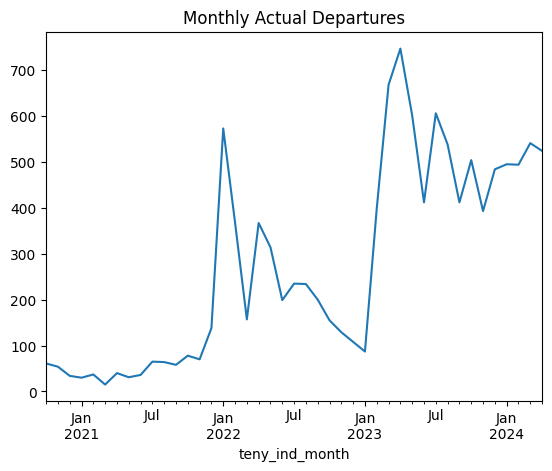

In [88]:
#Idősor elemzés
data_analysis['teny_ind_month'] = data_analysis['teny_ind'].dt.to_period('M')
monthly_departures = data_analysis.groupby('teny_ind_month').size()
monthly_departures.plot(kind='line', title='Monthly Actual Departures')

In [89]:
# Összehasonlító elemzés: terv vs teny
data_analysis['departure_delay'] = abs((data_analysis['teny_ind'] - data_analysis['terv_ind']).dt.total_seconds() / 60)  # in minutes
print(data_analysis['departure_delay'].describe())

count     11755.000000
mean      49056.853934
std       94591.027576
min           0.000000
25%          65.000000
50%         218.000000
75%       50601.000000
max      504015.000000
Name: departure_delay, dtype: float64


In [90]:
data_analysis[data_analysis["departure_delay"] > 50000]

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv,travel_time_teny,teny_ind_month,departure_delay
301,2022-02-06 22:30:00,2022-06-02 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-01-02 21:24:00,2022-02-01 21:57:00,521960,158,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,2,6,22,30,0,5,2022,2,6,22,49,0,5,2022,1,2,21,24,0,52,2022,1,2,21,57,0,52,19,33,2022-01,50466.0
302,2022-02-13 22:30:00,2022-02-13 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-01-02 21:24:00,2022-02-01 21:57:00,521960,158,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,2,13,22,30,0,6,2022,2,13,22,49,0,6,2022,1,2,21,24,0,52,2022,1,2,21,57,0,52,19,33,2022-01,60546.0
303,2022-02-20 22:30:00,2022-02-20 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-01-02 21:24:00,2022-02-01 21:57:00,521960,158,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,2,20,22,30,0,7,2022,2,20,22,49,0,7,2022,1,2,21,24,0,52,2022,1,2,21,57,0,52,19,33,2022-01,70626.0
304,2022-02-27 22:30:00,2022-02-27 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-01-02 21:24:00,2022-02-01 21:57:00,521960,158,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,2,27,22,30,0,8,2022,2,27,22,49,0,8,2022,1,2,21,24,0,52,2022,1,2,21,57,0,52,19,33,2022-01,80706.0
305,2022-03-06 22:30:00,2022-06-03 22:49:00,Ferencv.Nyugati.r.,Soroksári út rendező,2022-01-02 21:24:00,2022-02-01 21:57:00,521960,158,tmDiesel,T,Ferencv.Nyugati.r.,Soroksári út rendező,2022,3,6,22,30,0,9,2022,3,6,22,49,0,9,2022,1,2,21,24,0,52,2022,1,2,21,57,0,52,19,33,2022-01,90786.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13592,2024-04-14 14:00:00,2024-04-14 20:51:00,Rajka,Ferencv.Nyugati.r.,2024-02-18 10:39:00,2024-02-18 14:34:00,2162020,655,tmElectric,T,Rajka,Ferencv.Nyugati.r.,2024,4,14,14,0,0,15,2024,4,14,20,51,0,15,2024,2,18,10,39,0,7,2024,2,18,14,34,0,7,411,235,2024-02,80841.0
13593,2024-03-31 14:00:00,2024-03-31 20:51:00,Rajka,Ferencv.Nyugati.r.,2024-02-18 10:39:00,2024-02-18 14:34:00,2162020,655,tmElectric,T,Rajka,Ferencv.Nyugati.r.,2024,3,31,14,0,0,13,2024,3,31,20,51,0,13,2024,2,18,10,39,0,7,2024,2,18,14,34,0,7,411,235,2024-02,60681.0
13594,2024-03-24 14:00:00,2024-03-24 20:51:00,Rajka,Ferencv.Nyugati.r.,2024-02-18 10:39:00,2024-02-18 14:34:00,2162020,655,tmElectric,T,Rajka,Ferencv.Nyugati.r.,2024,3,24,14,0,0,12,2024,3,24,20,51,0,12,2024,2,18,10,39,0,7,2024,2,18,14,34,0,7,411,235,2024-02,50601.0
13627,2024-04-14 14:00:00,2024-04-14 20:51:00,Rajka,Ferencv.Nyugati.r.,2024-02-25 11:07:00,2024-02-25 15:30:00,1323740,401,tmElectric,T,Rajka,Ferencv.Nyugati.r.,2024,4,14,14,0,0,15,2024,4,14,20,51,0,15,2024,2,25,11,7,0,8,2024,2,25,15,30,0,8,411,263,2024-02,70733.0


In [91]:
# Compare scheduled and actual travel times
data_analysis['travel_time_difference'] = abs(data_analysis['travel_time_teny'] - data_analysis['travel_time_terv'])
print(data_analysis['travel_time_difference'].describe())

count    11755.000000
mean        60.021097
std        110.694491
min          0.000000
25%         11.000000
50%         28.000000
75%         63.000000
max       1421.000000
Name: travel_time_difference, dtype: float64


In [92]:
# Correlation matrix for certain variables
correlation_matrix = data_analysis[['rakom_tom', 'vonathossz', 'travel_time_terv','travel_time_teny']].corr()
print(correlation_matrix)

                  rakom_tom  vonathossz  travel_time_terv  travel_time_teny
rakom_tom          1.000000    0.637579          0.050327          0.003261
vonathossz         0.637579    1.000000          0.138585          0.077459
travel_time_terv   0.050327    0.138585          1.000000          0.632365
travel_time_teny   0.003261    0.077459          0.632365          1.000000


In [93]:
# Analysis of train types and their frequencies
train_type_distribution = data_analysis['vonatnem'].value_counts()
print(train_type_distribution)

vonatnem
T       6810
M       4658
Gt       220
MÁ        29
EPRB      20
Nt         8
Ir         4
KPRB       4
Ko         1
Vi         1
Name: count, dtype: int64


In [94]:
# Average actual travel time by train type
average_travel_time_by_type = data_analysis.groupby('vonatnem')['travel_time_teny'].mean()
print(average_travel_time_by_type)

vonatnem
EPRB     85.350000
Gt      133.577273
Ir       68.500000
KPRB    113.500000
Ko      240.000000
M       129.815157
MÁ      116.068966
Nt      223.625000
T       137.232159
Vi       67.000000
Name: travel_time_teny, dtype: float64


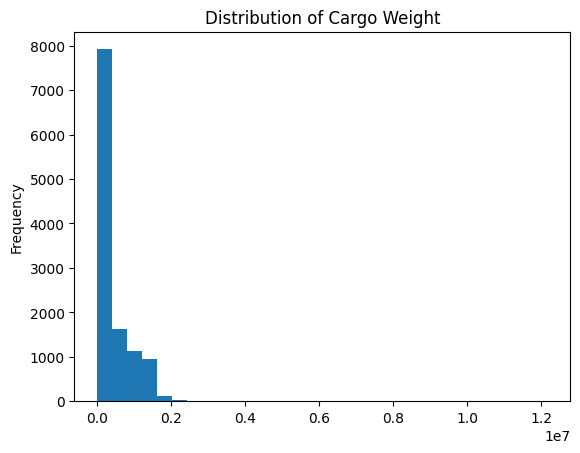

In [95]:
# Histogram for 'rakom_tom'
data_analysis['rakom_tom'].plot(kind='hist', bins=30, title='Distribution of Cargo Weight')
plt.show()

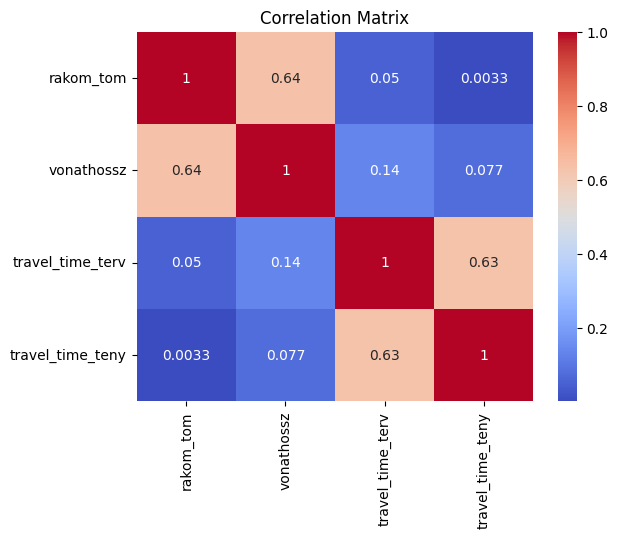

In [96]:
# Heat map for correlations
import seaborn as sns

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Normalizálás

In [97]:
dataset.drop('terv_ind', axis=1, inplace=True)
dataset.drop('terv_erk', axis=1, inplace=True)
dataset.drop('teny_ind', axis=1, inplace=True)
dataset.drop('teny_erk', axis=1, inplace=True)

In [98]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

OneHotEncoding


In [99]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-99-a4fce10cc6af>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
<ipython-input-99-a4fce10cc6af>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inputs[encoded_cols] = encoder.tran

In [100]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [101]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=50, max_depth=4)

In [102]:
%%time
model.fit(X, targets)

CPU times: user 2.24 s, sys: 26.9 ms, total: 2.27 s
Wall time: 1.26 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [103]:
preds = model.predict(X)

In [104]:
def mse(a, b):
  return mean_squared_error(a, b, squared=True)

In [105]:
def mae(a, b):
  return mean_absolute_error(a,b)

In [106]:
xgbRegressorTrainMSE = mse(preds, targets)
xgbRegressorTrainMAE = mae(preds, targets)


print("mse (train): ",mse(preds, targets))
print("mae (train): ",mae(preds, targets))

preds_test = model.predict(X_test)

xgbRegressorTestMSE = mse(preds_test, y_test)
xgbRegressorTestMAE = mae(preds_test, y_test)

print("mse (train): ",mse(preds_test, y_test))
print("mae (train): ",mae(preds_test, y_test))

mse (train):  4317.1628026648405
mae (train):  36.04935810052485
mse (train):  10112.861476356136
mae (train):  45.1003077241764


In [107]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
importance_df.head()

,feature,importance
30,travel_time_terv,0.115613
265,vontat_mode_tmDiesel,0.043678
561,erk_teny_Ferencv.Nyugati.r.,0.033187
570,erk_teny_Győr-Rendező,0.031242
521,erk_teny_Baja,0.031148


In [108]:
X = inputs[importance_df[importance_df.importance > 0.001].feature].copy()
X_test = test_inputs[importance_df[importance_df.importance > 0.001].feature].copy()

In [109]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=50, max_depth=4)

In [110]:
%%time
model.fit(X, targets)

CPU times: user 393 ms, sys: 5.84 ms, total: 398 ms
Wall time: 227 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [111]:
preds = model.predict(X)

In [112]:
xgbRegressorImportantTrainMSE = mse(preds, targets)
xgbRegressorImportantTrainMAE = mae(preds, targets)

print("mse: ",mse(preds, targets))
print("mae: ",mae(preds, targets))

mse:  4319.8701345733525
mae:  35.8878125442019


In [113]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
importance_df.head()

,feature,importance
0,travel_time_terv,0.074043
3,erk_teny_Győr-Rendező,0.035751
4,erk_teny_Baja,0.035643
5,ind_nev_terv_Tatabánya,0.030835
6,ind_nev_terv_Tapolca,0.030438


In [114]:
def train_and_evaluateMSE(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_mse = mse(model.predict(X_train), train_targets)
    val_mse = mse(model.predict(X_val), val_targets)
    train_mae = mae(model.predict(X_train), train_targets)
    val_mae = mae(model.predict(X_val), val_targets)
    return model, train_mse, val_mse

In [115]:
def train_and_evaluateMAE(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_mse = mse(model.predict(X_train), train_targets)
    val_mse = mse(model.predict(X_val), val_targets)
    train_mae = mae(model.predict(X_train), train_targets)
    val_mae = mae(model.predict(X_val), val_targets)
    return model, train_mae, val_mae

In [116]:
kfold = KFold(n_splits=5)

In [117]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_mse, val_mse = train_and_evaluateMSE(X_train,
                                                     train_targets,
                                                     X_val,
                                                     val_targets,
                                                     max_depth=4,
                                                     n_estimators=20)
    models.append(model)
    print('Train MSE: {}, Validation MSE: {}'.format(train_mse, val_mse))

Train MSE: 6921.852940491675, Validation MSE: 10777.288983856275
Train MSE: 7485.002171010444, Validation MSE: 10672.48635612177
Train MSE: 6243.696742345973, Validation MSE: 10346.914050808433
Train MSE: 7376.47214727618, Validation MSE: 8270.25928746159
Train MSE: 6751.695011396116, Validation MSE: 15155.583286989036


In [118]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_mae, val_mae = train_and_evaluateMAE(X_train,
                                                     train_targets,
                                                     X_val,
                                                     val_targets,
                                                     max_depth=4,
                                                     n_estimators=20)
    models.append(model)
    print('Train MSE: {}, Validation MAE: {}'.format(train_mae, val_mae))

Train MSE: 43.983073996686166, Validation MAE: 48.01185941174717
Train MSE: 44.005404219370924, Validation MAE: 50.24579977033205
Train MSE: 41.454216588199124, Validation MAE: 46.418605250547465
Train MSE: 45.209665077970904, Validation MAE: 46.362884138855165
Train MSE: 42.60602236554631, Validation MAE: 54.1493862986927


In [119]:
def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [120]:
preds = predict_avg(models, X_train)
preds

array([ 55.811787,  89.91589 , 142.47005 , ..., 222.52023 ,  54.177345,
        91.75883 ], dtype=float32)

In [121]:
drop_col = ["ind_nev_terv", "vontat_mode", "vonatnem", "ind_teny", "erk_teny"]
inputs.drop(drop_col, axis = 1, inplace = True)
test_inputs.drop(drop_col, axis = 1, inplace = True)


In [122]:
from sklearn.model_selection import RandomizedSearchCV


# ## Hyper Parameter Optimization
# n_estimators = [50, 75, 100, 200]
# max_depth = [2, 3, 5, 10, 15]
# learning_rate=[0.05,0.1,0.15,0.2]
# min_child_weight=[1,2,3,4]

# # Define the grid of hyperparameters to search
# hyperparameter_grid = {
#     'n_estimators': n_estimators,
#     'max_depth':max_depth,
#     'learning_rate':learning_rate,
#     'min_child_weight':min_child_weight
#     }

# # Set up the random search with 4-fold cross validation
# random_cv = RandomizedSearchCV(estimator=model,
#             param_distributions=hyperparameter_grid,
#             cv=5, n_iter=50,
#             scoring = 'neg_mean_absolute_error',n_jobs = 5,
#             verbose = 5,
#             return_train_score = True,
#             random_state=42)

# random_cv.fit(inputs,targets)

# print(random_cv.best_estimator_)

In [123]:
def train_and_evaluateMSE(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.15, max_delta_step=None, max_depth=10,
             min_child_weight=1, monotone_constraints=None,
             n_estimators=200, n_jobs=-1, num_parallel_tree=None,
             random_state=42, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=None, tree_method=None, validate_parameters=1,
             verbosity=None)

    model.fit(X_train, train_targets)
    train_mse = mse(model.predict(X_train), train_targets)
    val_mse = mse(model.predict(X_val), val_targets)

    return model, train_mse, val_mse

In [124]:
def train_and_evaluateMAE(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.15, max_delta_step=None, max_depth=10,
             min_child_weight=1, monotone_constraints=None,
             n_estimators=200, n_jobs=-1, num_parallel_tree=None,
             random_state=42, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=None, tree_method=None, validate_parameters=1,
             verbosity=None)
    model.fit(X_train, train_targets)

    train_mae = mae(model.predict(X_train), train_targets)
    val_mae = mae(model.predict(X_val), val_targets)

    return model, train_mae, val_mae

In [125]:
kfold = KFold(n_splits=5)
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_mse, val_mse = train_and_evaluateMSE(X_train,
                                                     train_targets,
                                                     X_val,
                                                     val_targets,
                                                     max_depth=4,
                                                     n_estimators=20)
    models.append(model)
    print('Train MSE: {}, Validation MSE: {}'.format(train_mse, val_mse))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:58:42] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)


Train MSE: 0.28650566790795357, Validation MSE: 8494.662661977069
Train MSE: 0.6255421034327342, Validation MSE: 9320.68502153545
Train MSE: 0.6765217142791615, Validation MSE: 10982.580424476526
Train MSE: 0.7829712979383787, Validation MSE: 5818.535275310899
Train MSE: 0.5702590095605408, Validation MSE: 13437.41801150058


In [126]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_mae, val_mae = train_and_evaluateMAE(X_train,
                                                     train_targets,
                                                     X_val,
                                                     val_targets,
                                                     max_depth=4,
                                                     n_estimators=20)
    models.append(model)
    print('Train MSE: {}, Validation MAE: {}'.format(train_mae, val_mae))

Train MSE: 0.3420342544913835, Validation MAE: 30.00552615418324
Train MSE: 0.4967483684524726, Validation MAE: 34.57215381479785
Train MSE: 0.5231169053972836, Validation MAE: 35.455874490853795
Train MSE: 0.5310118254531613, Validation MAE: 29.39003343683608
Train MSE: 0.4786282462876708, Validation MAE: 38.801235506092524


In [127]:
regressor = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.15, max_delta_step=None, max_depth=10,
             min_child_weight=1, monotone_constraints=None,
             n_estimators=200, n_jobs=-1, num_parallel_tree=None,
             random_state=42, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=None, tree_method=None, validate_parameters=1,
             verbosity=None)

regressor.fit(inputs,targets)
y_pred = regressor.predict(test_inputs)

In [128]:
test_pred = regressor.predict(test_inputs)

xgbRegressorGsHptTestMSE = mse(test_pred, y_test)
xgbRegressorGsHptTestMAE =  mae(test_pred, y_test)

print("mse: ",mse(test_pred, y_test))
print("mae: ",mae(test_pred, y_test))

mse:  9528.506277978666
mae:  34.47869051540408


In [129]:
train_pred = regressor.predict(inputs)

xgbRegressorGsHptTrainMSE = mse(train_pred, targets)
xgbRegressorGsHptTrainMAE =  mae(train_pred, targets)

print("mse: ",mse(train_pred, targets))
print("mae: ",mae(train_pred, targets))

mse:  57.375860007287905
mae:  5.215083258500885


In [130]:
test_targets_xgb = y_test
test_targets_xgb["test_pred"] = test_pred

#4377
idx = dataset_min_change.index.intersection(test_inputs.index)
print(idx)
dataset_min_changeXGB = dataset_min_change.loc[idx]
dataset_min_changeXGB["y_test"] = test_targets_xgb["travel_time_teny"]
dataset_min_changeXGB["predicted_travel_time"] = test_targets_xgb["test_pred"]
dataset_min_changeXGB.to_csv('submissionXGB.csv', index=None)

Index([    4,     5,     9,    12,    14,    18,    21,    33,    35,    48,
       ...
       13933, 13937, 13940, 13949, 13953, 13954, 13960, 13964, 13965, 13967],
      dtype='int64', length=3527)


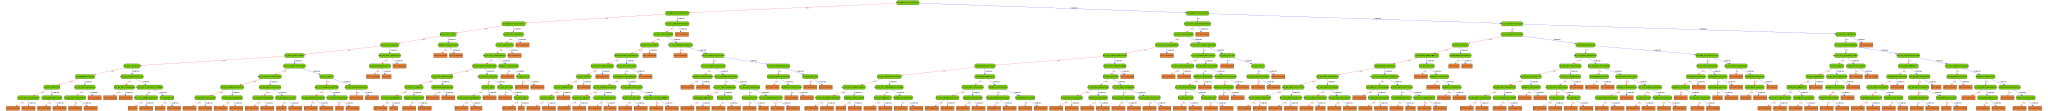

In [131]:
node_params = {
    'shape':'box',
    'style':'filled, rounded',
    'fillcolor':'#78cbe'
}
leaf_params = {
    'shape':'box',
    'style':'filled',
    'fillcolor':'#e48038'
}
image = xgb.to_graphviz(regressor, num_trees=0,size="1,1", condition_node_params=node_params, leaf_node_params=leaf_params)
image.graph_attr = {'dpi':'400'}
image.render('xgb_individualtree', format = 'png')
image

In [132]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn import metrics

y_test.drop('test_pred', axis = 1, inplace = True)

model = RandomForestRegressor(random_state=1)
model.fit(inputs, targets)
predicted_values = model.predict(test_inputs)
predicted_valuesTrain = model.predict(inputs)

randomForestRegressorTrainMSE = metrics.mean_squared_error(targets, predicted_valuesTrain)
randomForestRegressorTrainMAE = metrics.mean_absolute_error(targets, predicted_valuesTrain)
randomForestRegressorTestMSE = metrics.mean_squared_error(y_test, predicted_values)
randomForestRegressorTestMAE = metrics.mean_absolute_error(y_test, predicted_values)

print("mean squared error (train): ",metrics.mean_squared_error(targets, predicted_valuesTrain))
print("mean squared error (test): ",metrics.mean_squared_error(y_test, predicted_values))
print("mean absolute error (train): ",metrics.mean_absolute_error(targets, predicted_valuesTrain))
print("mean absolute error (test): ",metrics.mean_absolute_error(y_test, predicted_values))

<ipython-input-132-8733fe88dc6c>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(inputs, targets)


mean squared error (train):  1449.9946125546912
mean squared error (test):  11116.8119523391
mean absolute error (train):  14.453299708313077
mean absolute error (test):  39.75493337113694


In [133]:
predicted_values

array([ 33.94,  66.  , 122.  , ..., 391.88,  29.33, 314.5 ])

In [134]:
test_targets = y_test
test_targets["predicted_values"] = predicted_values
test_targets

,travel_time_teny,predicted_values
2776,32,33.94
1865,66,66.00
11298,122,122.00
12738,31,32.99
13854,17,30.17
...,...,...
11162,275,275.15
10495,242,242.00
11606,390,391.88
12188,22,29.33


In [135]:
dataset_min_change

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear
1,2020-10-04 00:30:00,2020-10-04 00:35:00,Vámosgyörk-Tartálypark ipvk. pvh.,Vámosgyörk,2020-10-05 01:20:00,2020-10-05 01:35:00,0.0,20.0,NaN,M,Vámosgyörk-Tartálypark ipvk. pvh.,Vámosgyörk,2020,10,4,0,30,0,40,2020,10,4,0,35,0,40,2020,10,5,1,20,0,41,2020,10,5,1,35,0,41
4,2020-10-06 13:30:00,2020-10-06 13:39:00,Szajol,Szolnok,2020-10-06 11:33:00,2020-10-06 14:35:00,0.0,36.0,NaN,M,Szajol,Szolnok,2020,10,6,13,30,0,41,2020,10,6,13,39,0,41,2020,10,6,11,33,0,41,2020,10,6,14,35,0,41
5,2020-10-06 22:00:00,2020-10-06 22:44:00,Zalakomár,Gyékényes,2020-10-06 20:57:00,2020-10-06 23:22:00,0.0,20.0,NaN,M,Zalakomár,Gyékényes,2020,10,6,22,0,0,41,2020,10,6,22,44,0,41,2020,10,6,20,57,0,41,2020,10,6,23,22,0,41
6,2020-10-07 16:00:00,2020-10-07 17:17:00,Debrecen,Szajol,2020-10-07 14:02:00,2020-10-07 16:25:00,0.0,16.0,NaN,M,Debrecen,Szajol,2020,10,7,16,0,0,41,2020,10,7,17,17,0,41,2020,10,7,14,2,0,41,2020,10,7,16,25,0,41
7,2020-10-07 18:00:00,2020-10-07 18:05:00,Vámosgyörk,Vámosgyörk-Tartálypark ipvk. pvh.,2020-10-07 17:23:00,2020-10-07 17:31:00,0.0,19.0,NaN,M,Vámosgyörk,Vámosgyörk-Tartálypark ipvk. pvh.,2020,10,7,18,0,0,41,2020,10,7,18,5,0,41,2020,10,7,17,23,0,41,2020,10,7,17,31,0,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13963,2024-04-26 07:00:00,2024-04-26 07:21:00,Szerencs,Tállya,2024-04-26 07:21:00,2024-04-26 08:11:00,0.0,411.0,NaN,T,Szerencs,Tállya,2024,4,26,7,0,0,17,2024,4,26,7,21,0,17,2024,4,26,7,21,0,17,2024,4,26,8,11,0,17
13964,2024-04-26 08:00:00,2024-04-26 08:28:00,Ferencv.Nyugati.r.,Soroksár-Terminál,2024-04-26 08:16:00,2024-04-26 09:10:00,1532300.0,409.0,NaN,T,Ferencv.Nyugati.r.,Soroksár-Terminál,2024,4,26,8,0,0,17,2024,4,26,8,28,0,17,2024,4,26,8,16,0,17,2024,4,26,9,10,0,17
13965,2024-04-26 19:30:00,2024-04-26 21:55:00,Ferencv.Nyugati.r.,Dunaújváros,2024-04-26 19:05:00,2024-04-26 21:05:00,0.0,19.0,NaN,M,Ferencv.Nyugati.r.,Dunaújváros,2024,4,26,19,30,0,17,2024,4,26,21,55,0,17,2024,4,26,19,5,0,17,2024,4,26,21,5,0,17
13966,2024-04-26 19:00:00,2024-04-26 19:11:00,Rákosrendező,Dunakeszi,2024-04-26 19:00:00,2024-04-26 20:10:00,0.0,18.0,tmDiesel,M,Rákosrendező,Dunakeszi,2024,4,26,19,0,0,17,2024,4,26,19,11,0,17,2024,4,26,19,0,0,17,2024,4,26,20,10,0,17


In [136]:
#4525
idx = dataset_min_change.index.intersection(test_inputs.index)
print(idx)

Index([    4,     5,     9,    12,    14,    18,    21,    33,    35,    48,
       ...
       13933, 13937, 13940, 13949, 13953, 13954, 13960, 13964, 13965, 13967],
      dtype='int64', length=3527)


In [137]:
dataset_min_change = dataset_min_change.loc[idx]

In [138]:
dataset_min_change["y_test"] = test_targets["travel_time_teny"]
dataset_min_change["predicted_travel_time"] = test_targets["predicted_values"]

In [139]:
dataset_min_change

,terv_ind,terv_erk,ind_nev_terv,erk__terv,teny_ind,teny_erk,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,y_test,predicted_travel_time
4,2020-10-06 13:30:00,2020-10-06 13:39:00,Szajol,Szolnok,2020-10-06 11:33:00,2020-10-06 14:35:00,0.0,36.0,NaN,M,Szajol,Szolnok,2020,10,6,13,30,0,41,2020,10,6,13,39,0,41,2020,10,6,11,33,0,41,2020,10,6,14,35,0,41,182,91.54
5,2020-10-06 22:00:00,2020-10-06 22:44:00,Zalakomár,Gyékényes,2020-10-06 20:57:00,2020-10-06 23:22:00,0.0,20.0,NaN,M,Zalakomár,Gyékényes,2020,10,6,22,0,0,41,2020,10,6,22,44,0,41,2020,10,6,20,57,0,41,2020,10,6,23,22,0,41,145,201.81
9,2020-10-08 15:00:00,2020-10-08 19:34:00,Szolnok-Rendező,Kétegyháza,2020-10-08 04:16:00,2020-10-08 10:42:00,0.0,505.0,NaN,T,Szolnok-Rendező,Kétegyháza,2020,10,8,15,0,0,41,2020,10,8,19,34,0,41,2020,10,8,4,16,0,41,2020,10,8,10,42,0,41,386,460.15
12,2020-10-12 00:30:00,2020-10-12 01:57:00,Szolnok-Rendező,Füzesabony,2020-10-13 00:55:00,2020-10-13 02:54:00,0.0,20.0,NaN,M,Szolnok-Rendező,Füzesabony,2020,10,12,0,30,0,42,2020,10,12,1,57,0,42,2020,10,13,0,55,0,42,2020,10,13,2,54,0,42,119,134.61
14,2020-10-18 21:12:00,2020-10-18 23:53:00,Pétfürdő,Soroksári út rendező,2020-10-18 19:11:00,2020-10-18 22:31:00,0.0,0.0,NaN,M,Pétfürdő,Soroksári út rendező,2020,10,18,21,12,0,42,2020,10,18,23,53,0,42,2020,10,18,19,11,0,42,2020,10,18,22,31,0,42,200,226.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13954,2024-04-24 12:00:00,2024-04-24 12:17:00,Ferencváros,Soroksár-Terminál,2024-04-24 03:01:00,2024-04-24 03:53:00,0.0,18.0,NaN,M,Ferencváros,Soroksár-Terminál,2024,4,24,12,0,0,17,2024,4,24,12,17,0,17,2024,4,24,3,1,0,17,2024,4,24,3,53,0,17,52,42.57
13960,2024-04-26 01:00:00,2024-04-26 03:16:00,Apafa,Szerencs,2024-04-25 18:07:00,2024-04-25 19:49:00,0.0,409.0,NaN,T,Apafa,Szerencs,2024,4,26,1,0,0,17,2024,4,26,3,16,0,17,2024,4,25,18,7,0,17,2024,4,25,19,49,0,17,102,175.81
13964,2024-04-26 08:00:00,2024-04-26 08:28:00,Ferencv.Nyugati.r.,Soroksár-Terminál,2024-04-26 08:16:00,2024-04-26 09:10:00,1532300.0,409.0,NaN,T,Ferencv.Nyugati.r.,Soroksár-Terminál,2024,4,26,8,0,0,17,2024,4,26,8,28,0,17,2024,4,26,8,16,0,17,2024,4,26,9,10,0,17,54,95.19
13965,2024-04-26 19:30:00,2024-04-26 21:55:00,Ferencv.Nyugati.r.,Dunaújváros,2024-04-26 19:05:00,2024-04-26 21:05:00,0.0,19.0,NaN,M,Ferencv.Nyugati.r.,Dunaújváros,2024,4,26,19,30,0,17,2024,4,26,21,55,0,17,2024,4,26,19,5,0,17,2024,4,26,21,5,0,17,120,164.68


In [140]:
dataset_min_change.columns

Index(['terv_ind', 'terv_erk', 'ind_nev_terv', 'erk__terv', 'teny_ind',
       'teny_erk', 'rakom_tom', 'vonathossz', 'vontat_mode', 'vonatnem',
       'ind_teny', 'erk_teny', 'terv_ind_Year', 'terv_ind_Month',
       'terv_ind_Day', 'terv_ind_Hour', 'terv_ind_Minute', 'terv_ind_Second',
       'terv_ind_WeekOfYear', 'terv_erk_Year', 'terv_erk_Month',
       'terv_erk_Day', 'terv_erk_Hour', 'terv_erk_Minute', 'terv_erk_Second',
       'terv_erk_WeekOfYear', 'teny_ind_Year', 'teny_ind_Month',
       'teny_ind_Day', 'teny_ind_Hour', 'teny_ind_Minute', 'teny_ind_Second',
       'teny_ind_WeekOfYear', 'teny_erk_Year', 'teny_erk_Month',
       'teny_erk_Day', 'teny_erk_Hour', 'teny_erk_Minute', 'teny_erk_Second',
       'teny_erk_WeekOfYear', 'y_test', 'predicted_travel_time'],
      dtype='object')

In [141]:
dataset_min_change.to_csv('submissionRFR.csv', index=None)

In [142]:
parameters = {
    'n_estimators': [50,100,150,200],
    'max_depth': [item for item in range(3, 15+1)]
}

In [143]:
#inputs = x_train
#targets = y_train
#test_inputs = x_test
from sklearn.model_selection import GridSearchCV
# clf = GridSearchCV(model, parameters)
# gs  = clf.fit(inputs, targets.values.ravel())
# print(gs.best_params_)

In [144]:
model = RandomForestRegressor(random_state=1, max_depth=15, n_estimators=200)
model.fit(inputs, targets)

<ipython-input-144-39e41942ea37>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(inputs, targets)


RandomForestRegressor(max_depth=15, n_estimators=200, random_state=1)

In [145]:
y_pred_train = model.predict(inputs)

randomForestRegressorGsHptTrainMSE = metrics.mean_squared_error(targets, y_pred_train)
randomForestRegressorGsHptTrainMAE = metrics.mean_absolute_error(targets, y_pred_train)

print("mse: ",metrics.mean_squared_error(targets, y_pred_train))
print("mae: ",metrics.mean_absolute_error(targets, y_pred_train))

mse:  3113.9259497609237
mae:  32.096577752062274


In [146]:
y_test.drop('travel_time_teny', axis=1, inplace=True)
y_pred = model.predict(test_inputs)


randomForestRegressorGsHptTestMSE = metrics.mean_squared_error(y_test, y_pred)
randomForestRegressorGsHptTestMAE = metrics.mean_absolute_error(y_test, y_pred)

print("mse: ",metrics.mean_squared_error(y_test, y_pred))
print("mae: ",metrics.mean_absolute_error(y_test, y_pred))


mse:  312.98885057974024
mae:  12.997905329834289


In [147]:
print(y_test)

       predicted_values
2776              33.94
1865              66.00
11298            122.00
12738             32.99
13854             30.17
...                 ...
11162            275.15
10495            242.00
11606            391.88
12188             29.33
5380             314.50

[3527 rows x 1 columns]


In [148]:
dataset[numeric_cols] = scaler.transform(dataset[numeric_cols])

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(dataset[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
dataset[encoded_cols] = encoder.transform(dataset[categorical_cols])
X_test = dataset[numeric_cols + encoded_cols]
clf = model.fit(X_test, y)
all_pred = clf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-148-432563adf575>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[encoded_cols] = encoder.transform(dataset[categorical_cols])
<ipython-input-148-432563adf575>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[encoded_cols] = encoder

In [149]:
randomForestTreeGsHptAllMSE =  metrics.mean_squared_error(y, all_pred)
randomForestTreeGsHptAllMAE =  metrics.mean_absolute_error(y, all_pred)
print("mse: ",metrics.mean_squared_error(y, all_pred))
print("mae: ",metrics.mean_absolute_error(y, all_pred))

mse:  3570.1123022275574
mae:  33.91880829417751


Összegezve: modellek teljesítménye

In [150]:
x["pred"] = all_pred
x["travel_time_teny"] = y["travel_time_teny"]
x["eltérés"] = (all_pred - y["travel_time_teny"])

In [151]:
x[abs(x["eltérés"]) == min(abs(x["eltérés"]))]

,ind_nev_terv,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv,pred,travel_time_teny,eltérés
5596,Szerencs,0,412,NaN,T,Szerencs,Tállya,2023,11,29,7,0,0,48,2023,11,29,7,53,0,48,2023,11,29,7,43,0,48,2023,11,29,8,20,0,48,53,36.993106,37,-0.006894


In [152]:
x[abs(x["eltérés"]) == max(abs(x["eltérés"]))]

,ind_nev_terv,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv,pred,travel_time_teny,eltérés
8389,Kiskunhalas,0,18,NaN,M,Kiskunhalas,Kiskunfélegyháza,2022,11,29,19,22,0,48,2022,11,29,20,19,0,48,2022,11,29,20,28,0,48,2022,11,29,20,7,0,48,57,732.222853,1419,-686.777147


In [153]:
x

,ind_nev_terv,rakom_tom,vonathossz,vontat_mode,vonatnem,ind_teny,erk_teny,terv_ind_Year,terv_ind_Month,terv_ind_Day,terv_ind_Hour,terv_ind_Minute,terv_ind_Second,terv_ind_WeekOfYear,terv_erk_Year,terv_erk_Month,terv_erk_Day,terv_erk_Hour,terv_erk_Minute,terv_erk_Second,terv_erk_WeekOfYear,teny_ind_Year,teny_ind_Month,teny_ind_Day,teny_ind_Hour,teny_ind_Minute,teny_ind_Second,teny_ind_WeekOfYear,teny_erk_Year,teny_erk_Month,teny_erk_Day,teny_erk_Hour,teny_erk_Minute,teny_erk_Second,teny_erk_WeekOfYear,travel_time_terv,pred,travel_time_teny,eltérés
4,Szajol,0,36,NaN,M,Szajol,Szolnok,2020,10,6,13,30,0,41,2020,10,6,13,39,0,41,2020,10,6,11,33,0,41,2020,10,6,14,35,0,41,9,196.235373,182,14.235373
5,Zalakomár,0,20,NaN,M,Zalakomár,Gyékényes,2020,10,6,22,0,0,41,2020,10,6,22,44,0,41,2020,10,6,20,57,0,41,2020,10,6,23,22,0,41,44,128.358203,145,-16.641797
6,Debrecen,0,16,NaN,M,Debrecen,Szajol,2020,10,7,16,0,0,41,2020,10,7,17,17,0,41,2020,10,7,14,2,0,41,2020,10,7,16,25,0,41,77,131.351219,143,-11.648781
8,Békéscsaba,0,20,NaN,M,Békéscsaba,Szolnok-Rendező,2020,10,7,22,0,0,41,2020,10,7,23,23,0,41,2020,10,7,20,41,0,41,2020,10,7,22,36,0,41,83,150.802340,115,35.802340
9,Szolnok-Rendező,0,505,NaN,T,Szolnok-Rendező,Kétegyháza,2020,10,8,15,0,0,41,2020,10,8,19,34,0,41,2020,10,8,4,16,0,41,2020,10,8,10,42,0,41,274,371.737080,386,-14.262920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13963,Szerencs,0,411,NaN,T,Szerencs,Tállya,2024,4,26,7,0,0,17,2024,4,26,7,21,0,17,2024,4,26,7,21,0,17,2024,4,26,8,11,0,17,21,47.577104,50,-2.422896
13964,Ferencv.Nyugati.r.,1532300,409,NaN,T,Ferencv.Nyugati.r.,Soroksár-Terminál,2024,4,26,8,0,0,17,2024,4,26,8,28,0,17,2024,4,26,8,16,0,17,2024,4,26,9,10,0,17,28,74.484934,54,20.484934
13965,Ferencv.Nyugati.r.,0,19,NaN,M,Ferencv.Nyugati.r.,Dunaújváros,2024,4,26,19,30,0,17,2024,4,26,21,55,0,17,2024,4,26,19,5,0,17,2024,4,26,21,5,0,17,145,168.749498,120,48.749498
13966,Rákosrendező,0,18,tmDiesel,M,Rákosrendező,Dunakeszi,2024,4,26,19,0,0,17,2024,4,26,19,11,0,17,2024,4,26,19,0,0,17,2024,4,26,20,10,0,17,11,37.826180,70,-32.173820


In [154]:
x.to_csv('submissionAll.csv', index=None)

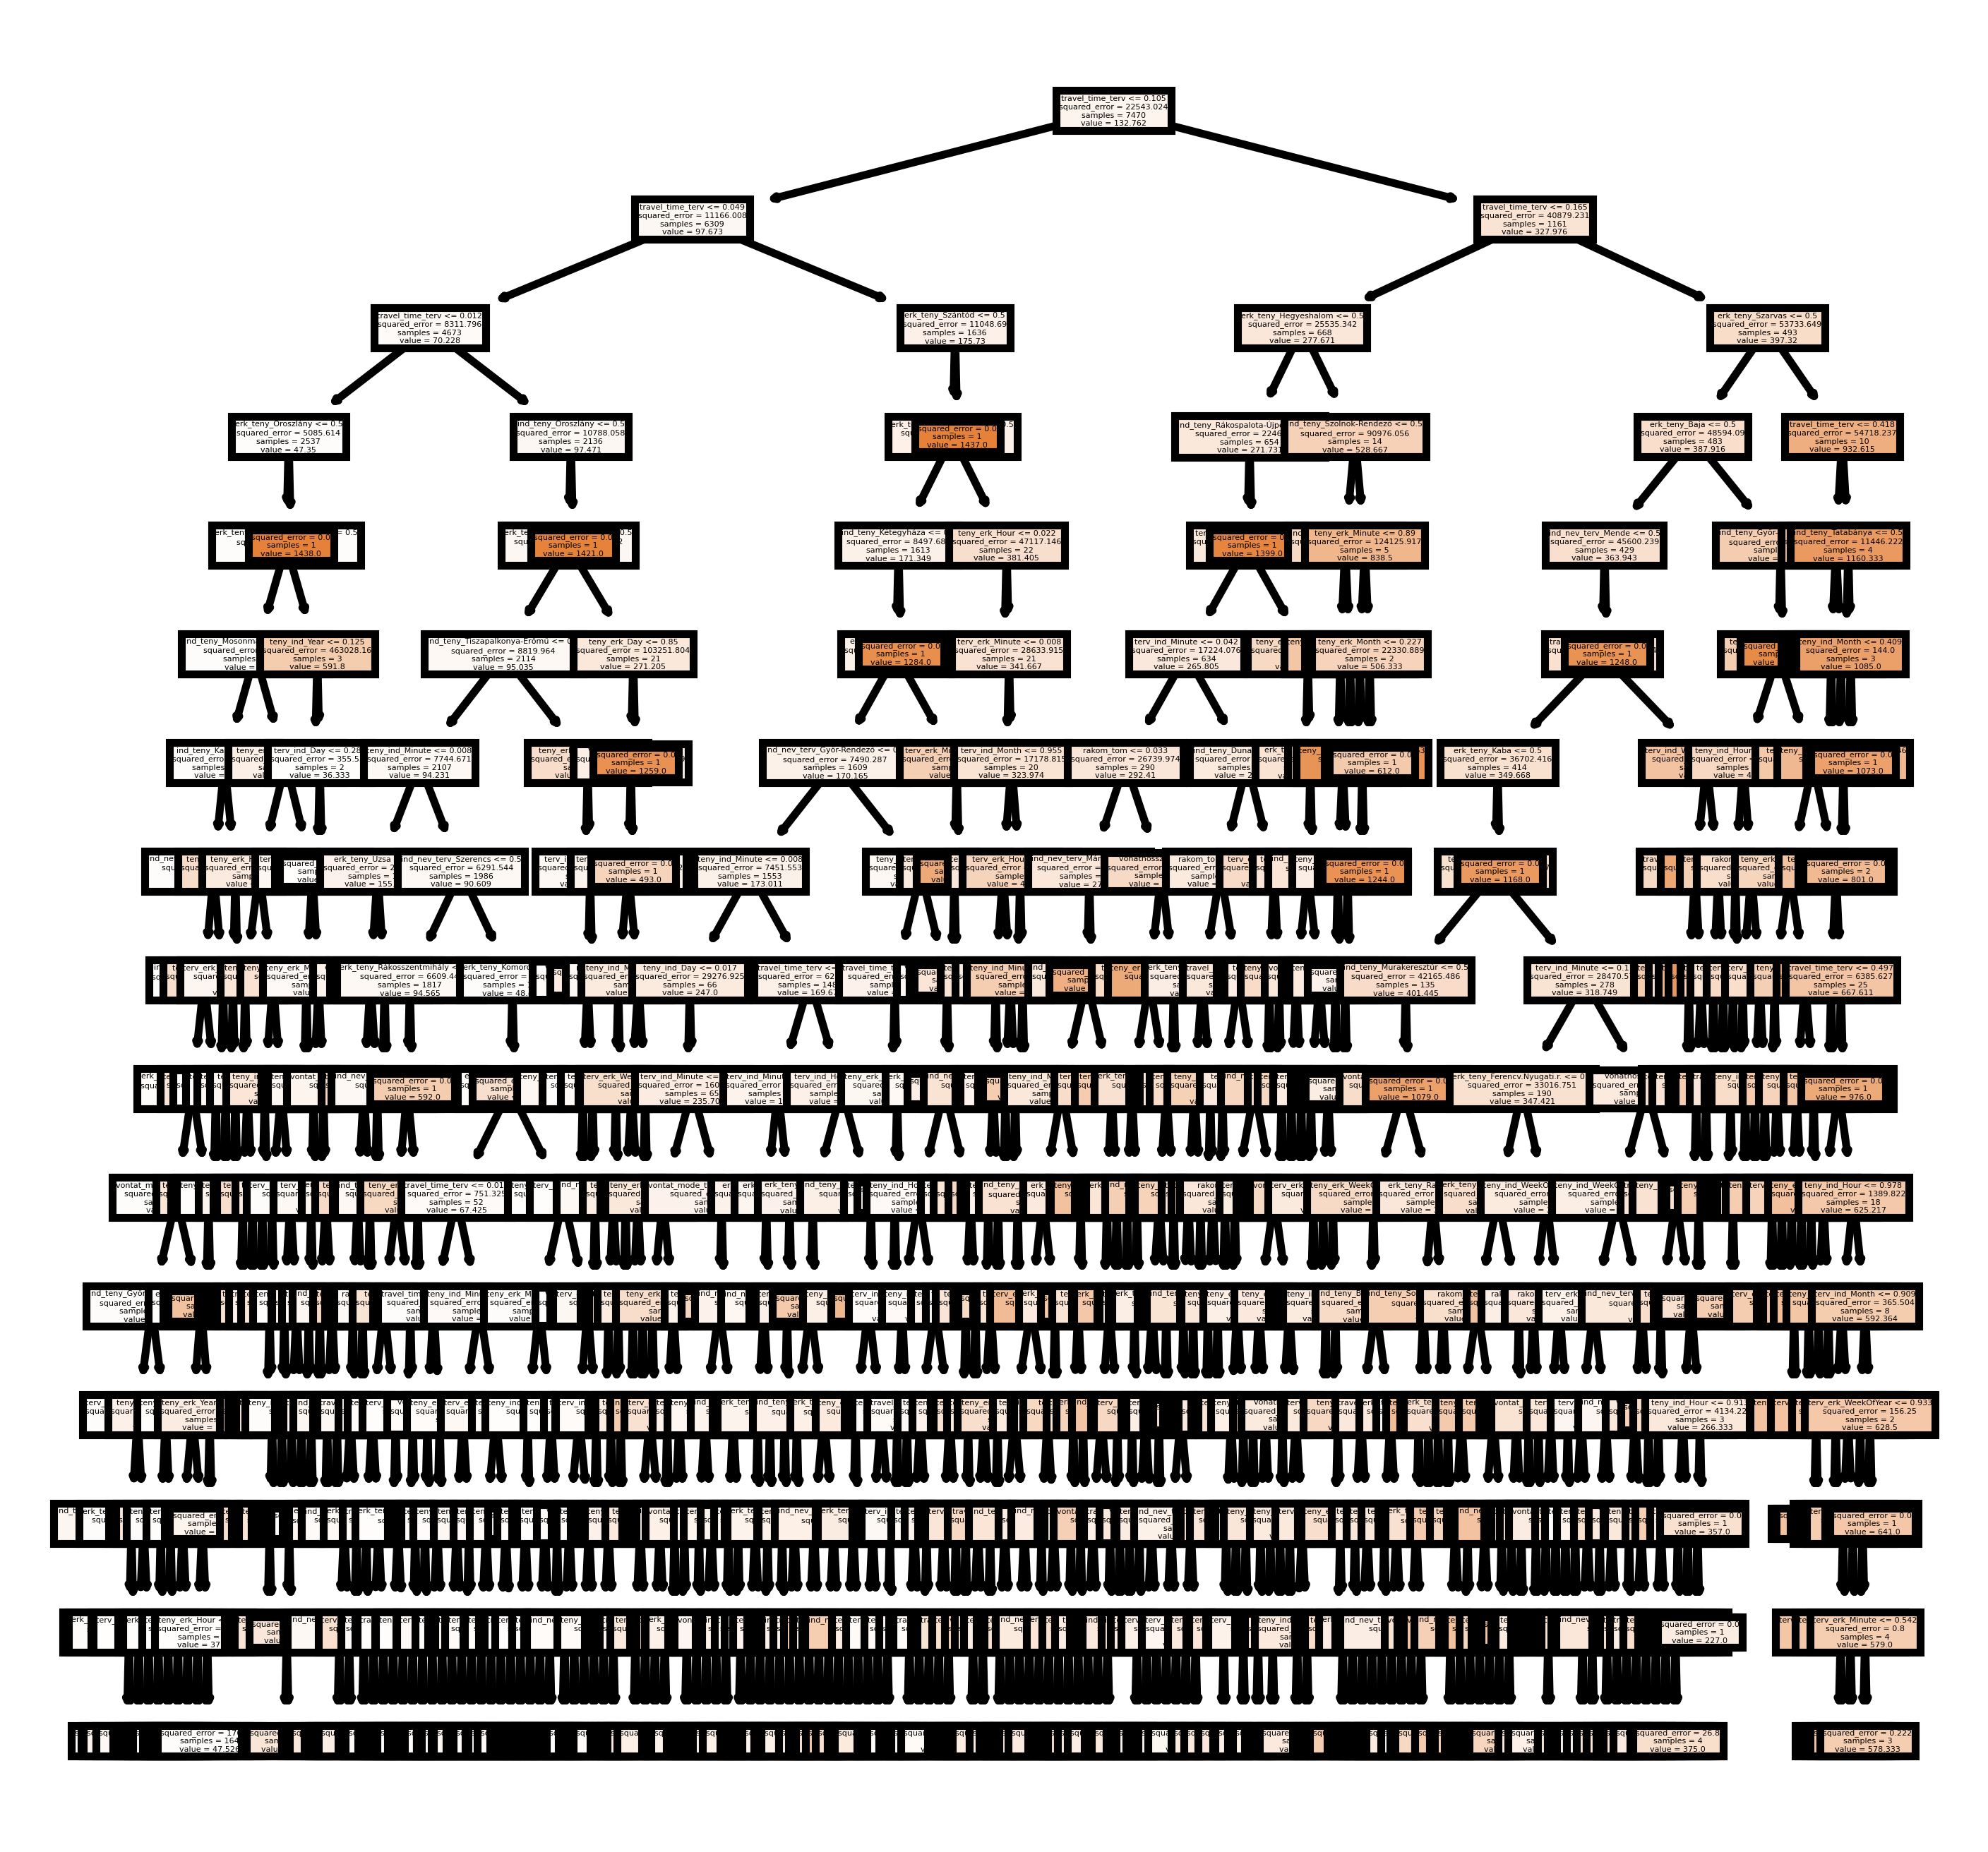

In [155]:
from sklearn import tree
fn=X_test.columns
cn=y.columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(model.estimators_[0],
               feature_names = fn,
               class_names=cn,
               filled = True);
fig.savefig('rf_individualtree.png')

In [156]:

print("tanuló adatokra XGBRegressor")
print("mse: ",xgbRegressorTrainMSE)
print("mae: ",xgbRegressorTrainMAE)

print("\n")

print("teszt adatokra XGBRegressor")
print("mse: ",xgbRegressorTestMSE)
print("mae: ",xgbRegressorTestMAE)

print("\n")

print("tanuló adatokra XGBRegressor fontosabb oszlopai")
print("mse: ",xgbRegressorImportantTrainMSE)
print("mae: ",xgbRegressorImportantTrainMAE)

print("\n")

print("tanuló adatokra XGBRegressor + GridSearch + Hyperparameter tunning")
print("mse: ",xgbRegressorGsHptTrainMSE)
print("mae: ",xgbRegressorGsHptTrainMAE)

print("\n")

print("teszt adatokra XGBRegressor + GridSearch + Hyperparameter tunning")
print("mse: ",xgbRegressorGsHptTestMSE)
print("mae: ",xgbRegressorGsHptTestMAE)

print("\n")

print("tanuló adatokra RandomForestRegressor")
print("mse: ",randomForestRegressorTrainMSE)
print("mae: ",randomForestRegressorTrainMSE)

print("\n")

print("teszt adatokra RandomForestRegressor")
print("mse: ",randomForestRegressorTestMSE)
print("mae: ",randomForestRegressorTestMAE)

print("\n")

print("tanuló adatokra RandomForestRegressor + GridSearch + Hyperparameter tunning")
print("mse: ",randomForestRegressorGsHptTrainMSE)
print("mae: ",randomForestRegressorGsHptTrainMAE)

print("\n")

print("teszt adatokra RandomForestRegressor + GridSearch + Hyperparameter tunning")
print("mse: ",randomForestRegressorGsHptTestMSE)
print("mae: ",randomForestRegressorGsHptTestMAE)

print("\n")

print("Az összes adatra RandomForestRegressor + GridSearch + Hyperparameter tunning")
print("mse: ",randomForestTreeGsHptAllMSE)
print("mae: ",randomForestTreeGsHptAllMAE)

tanuló adatokra XGBRegressor + GridSearch + Hyperparameter tunning
mse:  4317.1628026648405
mae:  36.04935810052485


teszt adatokra XGBRegressor + GridSearch + Hyperparameter tunning
mse:  10112.861476356136
mae:  45.1003077241764


tanuló adatokra XGBRegressor fontosabb oszlopai
mse:  4319.8701345733525
mae:  35.8878125442019


tanuló adatokra XGBRegressor + GridSearch + Hyperparameter tunning
mse:  57.375860007287905
mae:  5.215083258500885


teszt adatokra XGBRegressor + GridSearch + Hyperparameter tunning
mse:  9528.506277978666
mae:  34.47869051540408


tanuló adatokra RandomForestRegressor
mse:  1449.9946125546912
mae:  1449.9946125546912


teszt adatokra RandomForestRegressor
mse:  11116.8119523391
mae:  39.75493337113694


tanuló adatokra RandomForestRegressor + GridSearch + Hyperparameter tunning
mse:  3113.9259497609237
mae:  32.096577752062274


teszt adatokra RandomForestRegressor + GridSearch + Hyperparameter tunning
mse:  312.98885057974024
mae:  12.997905329834289


Az 